In [ ]:
# =============================================================================
# Machine Learning Tutorial: XGBoost Classification on the Bank Marketing Dataset
# =============================================================================
# This script demonstrates a complete pipeline for predicting whether a customer
# will subscribe to a term deposit (yes/no) using the Bank Marketing dataset.
# The pipeline includes:
# 1. Data loading from a CSV file ("bank.csv")
# 2. Data preprocessing: handling missing values, encoding categorical features,
#    and scaling numerical features.
# 3. Train-test split (80:20) with stratification.
# 4. Training an XGBoost classifier for binary classification.
# 5. Model evaluation using a classification report and confusion matrix.
# 6. Advanced visualizations:
#    - Confusion Matrix (using the 'mako' colormap)
#    - ROC Curve with AUC calculation
#    - Precision-Recall Curve
#    - Correlation Heatmap of selected features
#    - Radar Chart for Feature Importances via Permutation Importance
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve)
from sklearn.inspection import permutation_importance
from math import pi
from sklearn.calibration import calibration_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# -----------------------------------------------------------------------------
# Set a distinctive visualization style: "fivethirtyeight"
# -----------------------------------------------------------------------------
plt.style.use("fivethirtyeight")
sns.set_theme(style="whitegrid", palette="deep")

In [ ]:
# Data Loading and Exploration
# Load the Bank Marketing dataset from CSV (ensure bank.csv is in your working directory)
df = pd.read_csv("/content/bank_DETAILS.csv")

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
# -----------------------------------------------------------------------------
# 2. Data Preprocessing
# -----------------------------------------------------------------------------
# The dataset contains columns such as:
# ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
#  'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
# where 'y' is the target ('yes' for term deposit subscription, 'no' for not)

# Check for missing values (if any)
print("Missing values per column:\n", df.isna().sum())

Missing values per column:
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64


In [ ]:
# Convert target column 'deposit' to binary: 1 for 'yes', 0 for 'no'
# Assuming 'deposit' column has values like 'yes'/'no'
df['deposit'] = (df['deposit'].str.lower() == 'yes').astype(int)

# Separate features and target
X = df.drop('deposit', axis=1)
y = df['deposit']

In [ ]:
# Identify categorical and numerical columns.
# Given columns: age, job, marital, education, default, balance, housing, loan,
# contact, day, month, duration, campaign, pdays, previous, poutcome.
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_cols = [col for col in X.columns if col not in num_cols]

In [ ]:
print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [ ]:
# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])
# -----------------------------------------------------------------------------

In [ ]:
# -----------------------------------------------------------------------------
# 3. Data Splitting
# -----------------------------------------------------------------------------
# Split data into 80% training and 20% testing, stratifying on 'deposit'
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
# -----------------------------------------------------------------------------

Training set shape: (8929, 42)
Testing set shape: (2233, 42)


In [ ]:
# -----------------------------------------------------------------------------
# region 4. Building and Training the Deep Neural Network
# -----------------------------------------------------------------------------
# Define a simple DNN using Keras
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.2, callbacks=[early_stop], verbose=0)

In [ ]:
# -----------------------------------------------------------------------------
# 5. Model Evaluation
# -----------------------------------------------------------------------------
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      1175
           1       0.82      0.90      0.85      1058

    accuracy                           0.86      2233
   macro avg       0.86      0.86      0.86      2233
weighted avg       0.86      0.86      0.86      2233



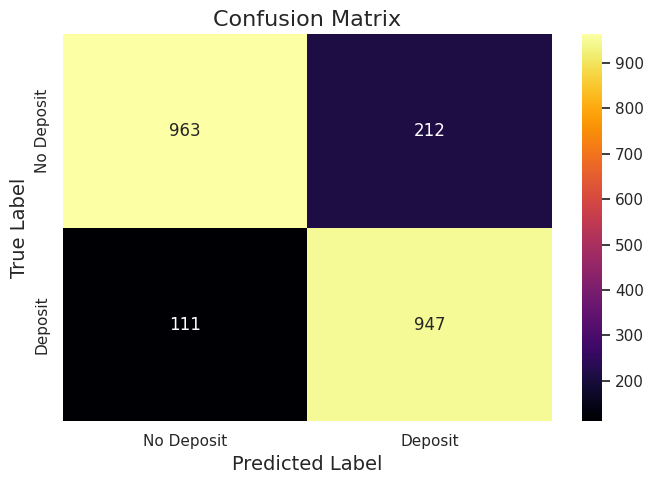

In [ ]:
# -----------------------------------------------------------------------------
# 6. Visualization: Confusion Matrix with "inferno" colormap
# -----------------------------------------------------------------------------
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="inferno",
            xticklabels=["No Deposit", "Deposit"],
            yticklabels=["No Deposit", "Deposit"])
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()

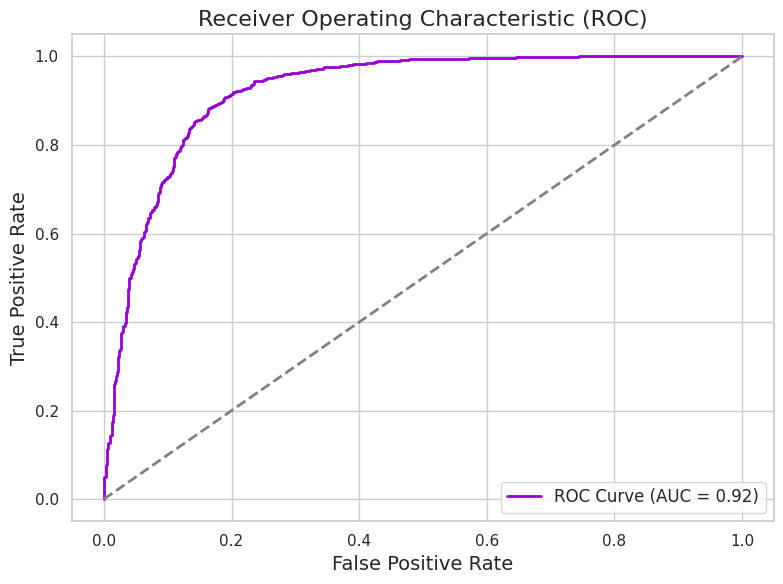

In [ ]:
# -----------------------------------------------------------------------------
# 7. Visualization: ROC Curve and AUC
# -----------------------------------------------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkviolet', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Receiver Operating Characteristic (ROC)", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------

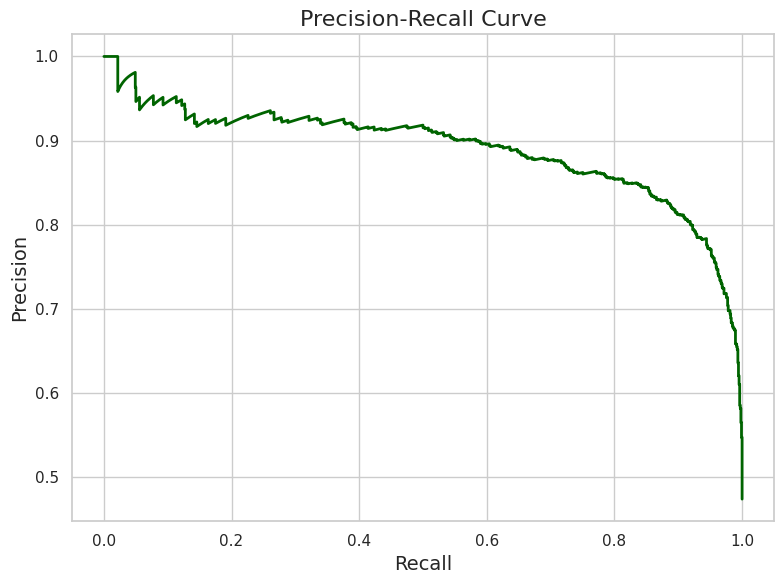

In [ ]:
# -----------------------------------------------------------------------------
# 8. Visualization: Precision-Recall Curve
# -----------------------------------------------------------------------------
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkgreen', lw=2)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall Curve", fontsize=16)
plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------

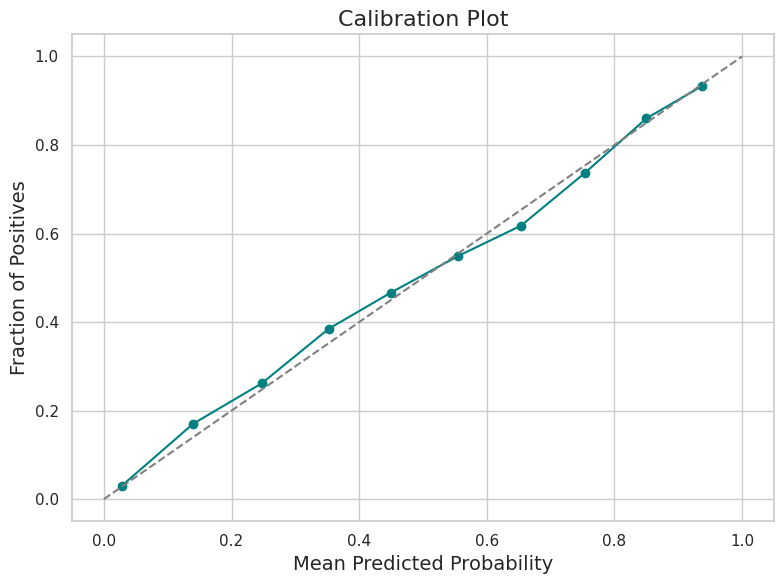

In [ ]:
# -----------------------------------------------------------------------------
# 9. Visualization: Calibration Plot
# -----------------------------------------------------------------------------
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='teal')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Mean Predicted Probability", fontsize=14)
plt.ylabel("Fraction of Positives", fontsize=14)
plt.title("Calibration Plot", fontsize=16)
plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━

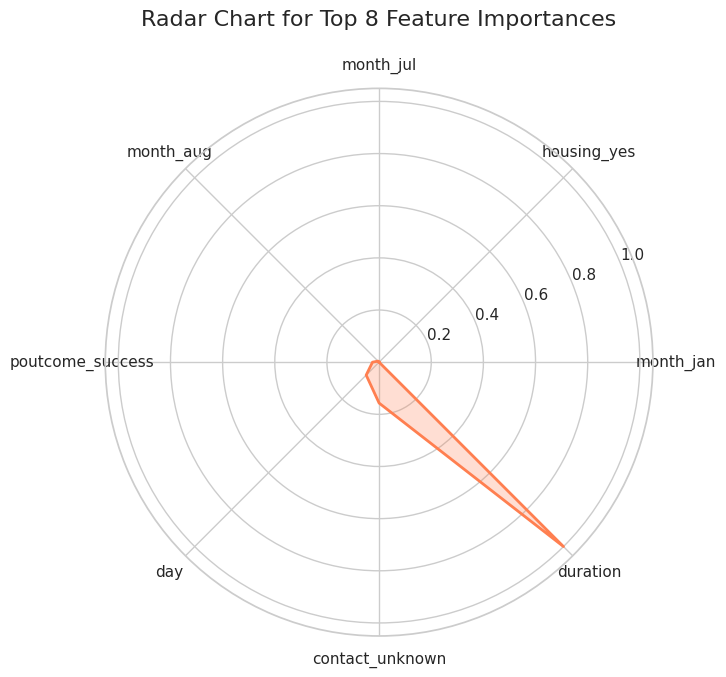

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. Wrapper to convert Keras model probabilities into binary class predictions
# -----------------------------------------------------------------------------
class WrappedModel:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self  # already trained

    def predict(self, X):
        probs = self.model.predict(X)
        return (probs.ravel() > 0.5).astype(int)  # ensure binary output

# -----------------------------------------------------------------------------
# 2. Compute permutation importance
# -----------------------------------------------------------------------------
wrapped_model = WrappedModel(model)  # 'model' should be your trained Keras Sequential model

perm_import = permutation_importance(
    estimator=wrapped_model,
    X=X_test,   # Scaled test data (used during training)
    y=y_test,
    n_repeats=10,
    random_state=42,
    scoring='accuracy'
)

importances = perm_import.importances_mean

# -----------------------------------------------------------------------------
# 3. Prepare feature names
# -----------------------------------------------------------------------------
# Make sure the feature names match the shape of X_test_scaled
if isinstance(X_test, np.ndarray):
    feature_names = np.array(X.columns[:X_test.shape[1]])  # from original DataFrame
else:
    feature_names = X_test.columns

# -----------------------------------------------------------------------------
# 4. Prepare data for radar chart
# -----------------------------------------------------------------------------
top_n = min(8, len(importances))  # Ensure we don’t exceed available features
top_idx = np.argsort(importances)[-top_n:]
top_features = feature_names[top_idx]
top_importances = importances[top_idx]

# Normalize to [0, 1] for radar plot
norm_importances = (top_importances - top_importances.min()) / (top_importances.max() - top_importances.min())

# Create full loop for radar chart
angles = np.linspace(0, 2 * np.pi, top_n, endpoint=False).tolist()
norm_importances = np.concatenate((norm_importances, [norm_importances[0]]))
angles += angles[:1]

# -----------------------------------------------------------------------------
# 5. Plot Radar Chart
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
ax.plot(angles, norm_importances, color='coral', linewidth=2, linestyle='solid')
ax.fill(angles, norm_importances, color='coral', alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), labels=top_features)
ax.set_title("Radar Chart for Top 8 Feature Importances", fontsize=16, y=1.10)
plt.tight_layout()
plt.show()